In [483]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
from astropy.time import Time
from astropy.coordinates import EarthLocation , Angle
# importing photutils to select a circular region of rad r around x, y
from photutils.aperture import CircularAperture, aperture_photometry

In [484]:
file = fits.open('hezeb8.fit')
file.info()

Filename: hezeb8.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      38   (765, 510)   int16 (rescales to uint16)   


In [485]:
file[0].header

SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                  765 /fastest changing axis                           
NAXIS2  =                  510 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2025-03-14T23:41:58' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =  0.50000000000000000 /Exposure time in seconds                        
EXPOSURE=  0.50000000000000000 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -9.3729062676215307 /CCD temperature at start of exposure in C       
XPIXSZ  =   9.00000000000000

In [486]:
date_obs_ut=file[0].header['DATE-OBS']
exptime=file[0].header['EXPTIME']
ped_offset_corr=file[0].header['PEDESTAL']
gain = file[0].header['EGAIN']
print('date and time:',date_obs_ut)
print('exposure time in sec:',exptime)
print('pedestal offset correction:',ped_offset_corr)
print('gain in electron per adu',gain)

date and time: 2025-03-14T23:41:58
exposure time in sec: 0.5
pedestal offset correction: -100
gain in electron per adu 2.5799999237060547


In [487]:
# calculation of zenith angle
ra_hms = (13,35,59.9)      # Right Ascension in (hours, minutes, seconds)
dec_dms = (-0,43,38.1)   # Declination in (degrees, minutes, seconds)
latitude = 18.5592         # Observer's latitude in degrees 
longitude = 73.8253        # Observer's longitude in degrees
utc_time = date_obs_ut  # UTC time of observation

# Convert RA (hours, min, sec) to degrees
ra = Angle(f"{ra_hms[0]}h{ra_hms[1]}m{ra_hms[2]}s").degree  # RA in degrees

# Convert Dec (deg, min, sec) to decimal degrees
dec = Angle(f"{dec_dms[0]}d{dec_dms[1]}m{dec_dms[2]}s").degree  # Dec in degrees

# Convert Dec and Latitude to radians
dec = np.radians(dec)
latitude = np.radians(latitude)

# Compute Local Sidereal Time (LST)
time = Time(utc_time)
location = EarthLocation.from_geodetic(lon=longitude, lat=latitude)
lst = time.sidereal_time("apparent", longitude).degree  # LST in degrees

# Convert LST and RA to radians
lst_rad = np.radians(lst)
ra_rad = np.radians(ra)

# Compute Hour Angle (H = LST - RA) in radians
H = lst_rad - ra_rad

# Apply the cosine formula for the zenith angle
cos_Z = np.sin(latitude) * np.sin(dec) + np.cos(latitude) * np.cos(dec) * np.cos(H)

# Ensure cos_Z is within valid range [-1,1] for arccos
cos_Z = np.clip(cos_Z, -1, 1)

# Compute Zenith Angle (Z) in degrees
Z = np.degrees(np.arccos(cos_Z))

print(f"Zenith Angle: {Z:.2f} degrees")

Zenith Angle: 41.46 degrees


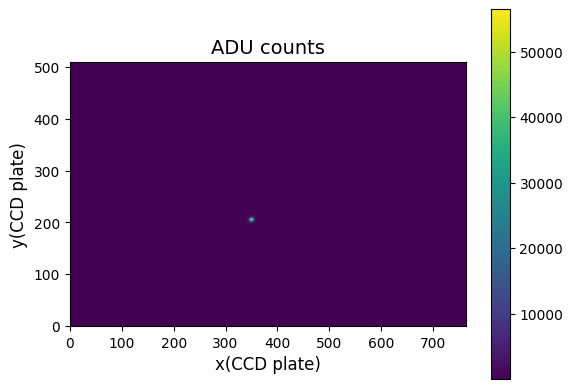

array([[132, 112, 129, ..., 109, 129, 120],
       [116, 126, 131, ..., 108, 132, 110],
       [118, 122, 128, ..., 133, 117, 113],
       ...,
       [116, 112, 118, ..., 120, 124, 112],
       [141, 119, 109, ..., 114, 111, 119],
       [115, 122, 103, ..., 111, 122, 124]], dtype=uint16)

In [488]:
image = file[0].data
plt.xlabel("x(CCD plate)", fontsize=12)
plt.ylabel("y(CCD plate)", fontsize=12)
plt.title("ADU counts", fontsize=14)
plt.imshow(image, origin='lower')
plt.colorbar()
plt.show()
image

[[49.53599854 18.57599945 44.89199867 ... 13.93199959 44.89199867
  30.95999908]
 [24.76799927 40.24799881 47.98799858 ... 12.38399963 49.53599854
  15.47999954]
 [27.86399918 34.05599899 43.34399872 ... 51.08399849 26.31599922
  20.1239994 ]
 ...
 [24.76799927 18.57599945 27.86399918 ... 30.95999908 37.1519989
  18.57599945]
 [63.46799812 29.41199913 13.93199959 ... 21.67199936 17.0279995
  29.41199913]
 [23.21999931 34.05599899  4.64399986 ... 17.0279995  34.05599899
  37.1519989 ]]


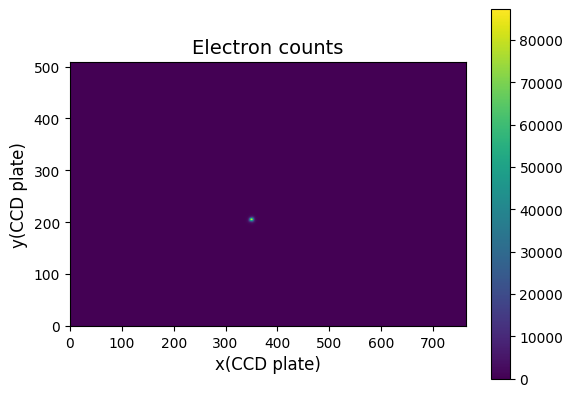

In [489]:
e_count= ((image*1.0)+ped_offset_corr)*gain #pedestal corrected electron counts
e_count= (e_count/exptime)*0.3 #scaling for uniform exposure time = electron counts per 0.3 second
print(e_count)
plt.imshow(e_count, origin='lower')
plt.xlabel("x(CCD plate)", fontsize=12)
plt.ylabel("y(CCD plate)", fontsize=12)
plt.title("Electron counts", fontsize=14)
plt.colorbar()
plt.show()

In [490]:
# center of source
max_value = np.max(e_count) # max electron count value
max_index = np.unravel_index(np.argmax(e_count), e_count.shape) # indices of max counts
print(e_count.shape)
print(f"Maximum Value: {max_value}")
print(f"Indices of Maximum Value: {max_index}")  # Output as (row, column) (y,x)

(510, 765)
Maximum Value: 87253.01741981506
Indices of Maximum Value: (205, 350)


counts of source plus backgound =  [ 254841.28522559  901044.52095154 1683869.77250294 2399778.60629242
 2942041.28396068 3308598.96655383 3544160.78250978 3697607.71897265
 3799676.86507211 3869555.54945551 3918686.03067274 3954738.45542905
 3982144.62438857 4003696.70446898]


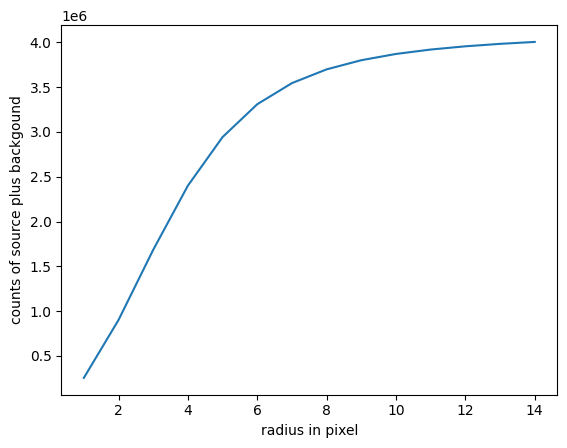

In [491]:
pos = (max_index[1],max_index[0]) # source center
# changing the radius and plotting counts vs px

electron_counts = [] 
radius= np.arange(1,15,1)

for i in radius:
    aper = CircularAperture(pos, r=i)
    each_table = aperture_photometry(e_count, aper)
    electron_counts.append(each_table['aperture_sum'].value)

electron_counts = (np.array(electron_counts)).flatten()
print('counts of source plus backgound = ',electron_counts)

plt.plot(radius, electron_counts)
plt.ylabel('counts of source plus backgound')
plt.xlabel('radius in pixel')
#plt.yscale('log')
plt.show()

counts of source =  [ 254751.68982628  900722.52606708 1683145.87496845 2398414.51552823
 2939813.35550513 3305333.61135628 3539757.66706475 3691887.58478852
 3792404.30685314 3860358.64161512 3907581.02598063 3941603.25942946
 3966702.61956976 3985737.24421848]


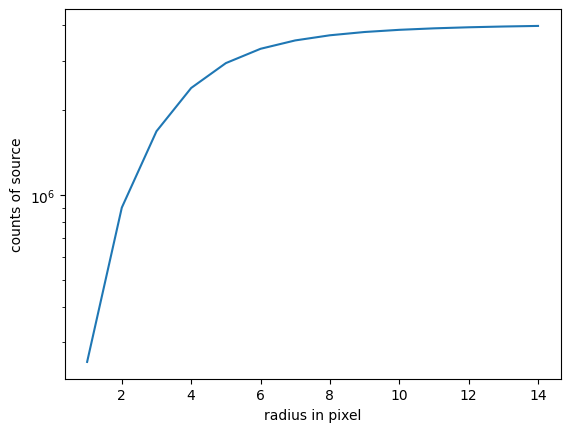

In [492]:
pos_bkg = (250,105) #background center for this source(in vicinity of source)

electron_counts_bkg = [] 

for i in radius:
    aper = CircularAperture(pos_bkg, r=i)
    each_table = aperture_photometry(e_count, aper)
    electron_counts_bkg.append(each_table['aperture_sum'].value)

electron_counts_bkg = (np.array(electron_counts_bkg)).flatten() 
electron_counts_source= electron_counts-electron_counts_bkg
print('counts of source = ',electron_counts_source)

plt.plot(radius, electron_counts_source)
plt.ylabel('counts of source')
plt.xlabel('radius in pixel')
plt.yscale('log')
plt.show()

In [493]:
# defining region of radius r around src and bkg

r=10
src_plus_bkg= electron_counts[r-1]
bkg= electron_counts_bkg[r-1]

print('source plus bkg count=',src_plus_bkg); print('background count=',bkg)

flux = src_plus_bkg - bkg
mag = -2.5*np.log10(flux)
sec= 1.0/np.cos(np.radians(Z))
print('magnitude= ',mag,'zenith angle in degrees= ',Z,'sec z=',sec)

source plus bkg count= 3869555.549455509
background count= 9196.907840385222
magnitude=  -16.46656913527981 zenith angle in degrees=  41.461133463231775 sec z= 1.334391886656718
